In [3]:
#imports needed for this notebook
import pandas as pd
import random
import datetime
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import shap

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Kickstarter Projects - Main Notebook

## Data Cleaning, EDA, Data Visualizations, Feature Engineering

In [4]:
df = pd.read_csv('kickstarter_projects.csv')

In [5]:
#looking through data attributes
print(df.info())
print(df.describe())
print(df['State'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB
None
                 ID          Goal       Pledged        Backers
count  3.748530e+05  3.748530e+05  3.748530e+05  374853.000000
mean   1.074656e+09  4.586378e+04  9.121073e+03     106.690359
std    6.191377e+08  1.158778e+06  9.132054e+04     911.718520
min    5.971000e+03  0.000000e+00  

In [6]:
print(df.isnull().sum())

ID             0
Name           0
Category       0
Subcategory    0
Country        0
Launched       0
Deadline       0
Goal           0
Pledged        0
Backers        0
State          0
dtype: int64


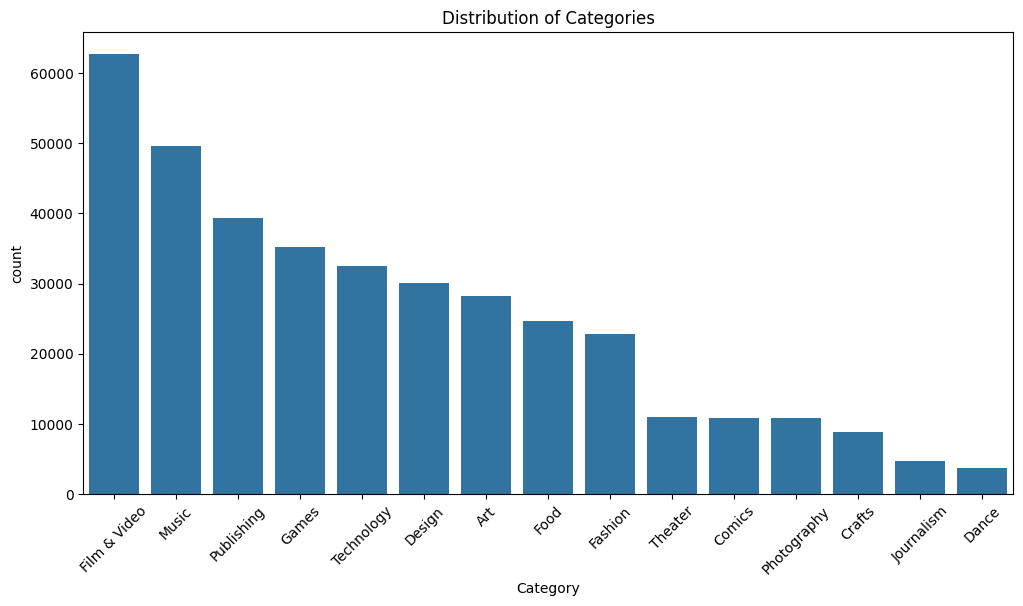

In [7]:
#(sub)category distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xticks(rotation=45)
plt.show()

In [8]:
#using IQR
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    print("Original data size: " str(len(df)))
    print("Filtered data size: " str(len(filtered_df)))
    return filtered_df
df = remove_outliers(df, 'Goal')

Original data size: 374853
Filtered data size: 330154


<ipython-input-9-18a5ee156cd7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Success'] = df['Goal'] <= df['Pledged']
<ipython-input-9-18a5ee156cd7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['State'], inplace=True)


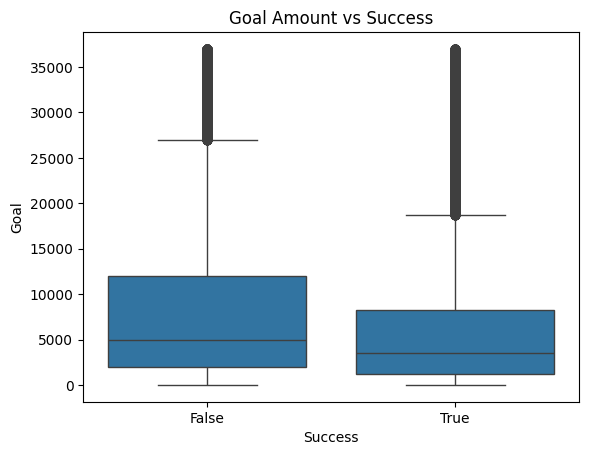

In [9]:
#defining what is a success
df = df[(df['State'] != 'Live') & (df['State'] != 'Suspended') & (df['State'] != 'Canceled')]
df['Success'] = df['Goal'] <= df['Pledged']
df.drop(columns=['State'], inplace=True)
sns.boxplot(data=df, x='Success', y='Goal')
plt.title('Goal Amount vs Success')
plt.show()

In [10]:
#feature engineering on date related objects
df["Launched"] = pd.to_datetime(df["Launched"])
df["Deadline"] = pd.to_datetime(df["Deadline"])

df['Launch Month'] = df['Launched'].dt.month
df['Launch Year'] = df['Launched'].dt.year
df['Deadline Month'] = df['Deadline'].dt.month
df['Deadline Year'] = df['Deadline'].dt.year

df['Campaign Length'] = (df['Deadline'] - df['Launched']).dt.days

#feature engineering on name
pattern_punc = re.compile(r"[[:punct:]]")
pattern_upper = re.compile(r"[A-Z]")
pattern_lower = re.compile(r"[a-z]")

df["Length_Name"] = [len(name) for name in df["Name"]]
df["Name_Word_Count"] = [len(list(name)) for name in df["Name"]]
df["Count_Punc"] = [len(re.findall(pattern_punc , sub)) if type(sub) == str else 0 for sub in df["Name"]]
df["Count_Uppers"] = [len(re.findall(pattern_upper , sub)) if type(sub) == str else 0 for sub in df["Name"]]
df["Count_Lowers"] = [len(re.findall(pattern_lower , sub)) if type(sub) == str else 0 for sub in df["Name"]]

df = pd.get_dummies(df, columns=['Category', "Subcategory",'Country'], drop_first=True)

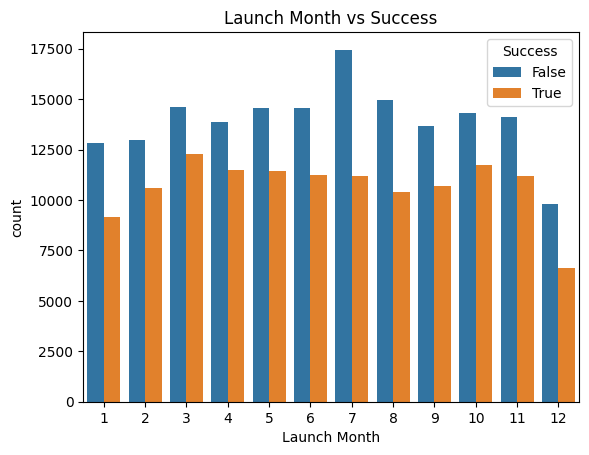

In [11]:
#months to success
sns.countplot(data=df, x='Launch Month', hue='Success')
plt.title('Launch Month vs Success')
plt.show()

In [12]:
#tokenization
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]
    return ' '.join(tokens)
df['Processed_Title'] = df['Name'].apply(preprocess_text)

#tf-idf
vectorizer = TfidfVectorizer(max_features=500)
X_title = vectorizer.fit_transform(df['Processed_Title'])

#sentiment analysis
df['Sentiment_Polarity'] = df['Name'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment_Subjectivity'] = df['Name'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [13]:
#Check for null values
df[df.isna().any(axis=1)]

,ID,Name,Launched,Deadline,Goal,Pledged,Backers,Success,Launch Month,Launch Year,...,Country_Norway,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom,Country_United States,Processed_Title,Sentiment_Polarity,Sentiment_Subjectivity


In [14]:
df = df.reset_index(drop=True)
X = df.drop(['ID', 'Name', 'Launched', 'Deadline', 'Pledged', 'Backers', 'Success', 'Processed_Title'], axis=1)

In [15]:
X.dtypes.value_counts()

,count
bool,193
int64,7
int32,4
float64,2


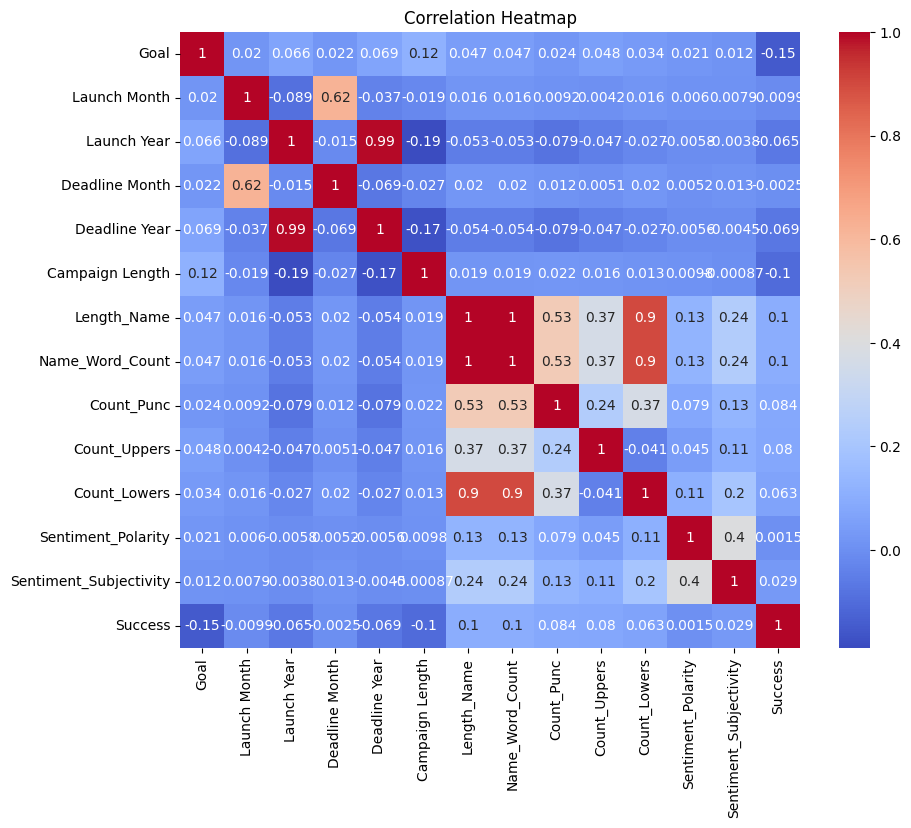

In [16]:
non_bool = X.select_dtypes(exclude=['bool'])
non_bool['Success'] = df['Success']

plt.figure(figsize=(10, 8))
sns.heatmap(non_bool.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Modeling

In [17]:
#modeling set up
X = pd.concat([X, pd.DataFrame(X_title.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)
print(X.columns)
y = df['Success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['Goal', 'Launch Month', 'Launch Year', 'Deadline Month',
       'Deadline Year', 'Campaign Length', 'Length_Name', 'Name_Word_Count',
       'Count_Punc', 'Count_Uppers',
       ...
       'work', 'works', 'world', 'worlds', 'year', 'years', 'york', 'young',
       'youth', 'zombie'],
      dtype='object', length=706)


Logistic Regression:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.65      0.76      0.70     33616
        True       0.59      0.47      0.53     25510

    accuracy                           0.63     59126
   macro avg       0.62      0.61      0.61     59126
weighted avg       0.63      0.63      0.63     59126



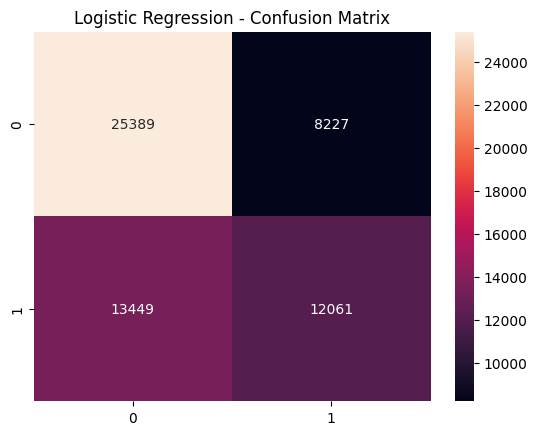

In [20]:
print("Logistic Regression:")
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

Decision Tree Classifier:
              precision    recall  f1-score   support

       False       0.65      0.66      0.66     33616
        True       0.54      0.53      0.54     25510

    accuracy                           0.61     59126
   macro avg       0.60      0.60      0.60     59126
weighted avg       0.60      0.61      0.60     59126



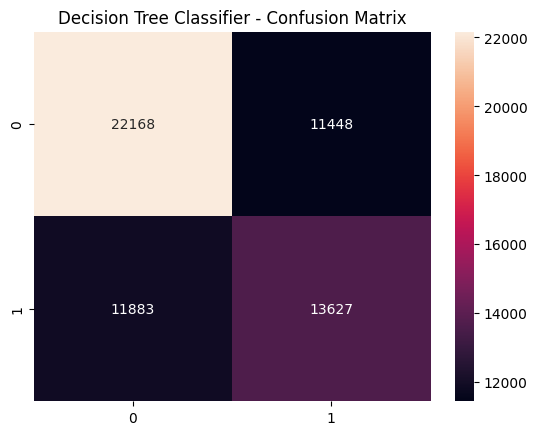

In [18]:
print("Decision Tree Classifier:")
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred_dt = dtc.predict(X_test)
print(classification_report(y_test, y_pred_dt))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d')
plt.title('Decision Tree Classifier - Confusion Matrix')
plt.show()

Random Forest Classifier:
              precision    recall  f1-score   support

       False       0.70      0.78      0.74     33616
        True       0.66      0.55      0.60     25510

    accuracy                           0.68     59126
   macro avg       0.68      0.67      0.67     59126
weighted avg       0.68      0.68      0.68     59126



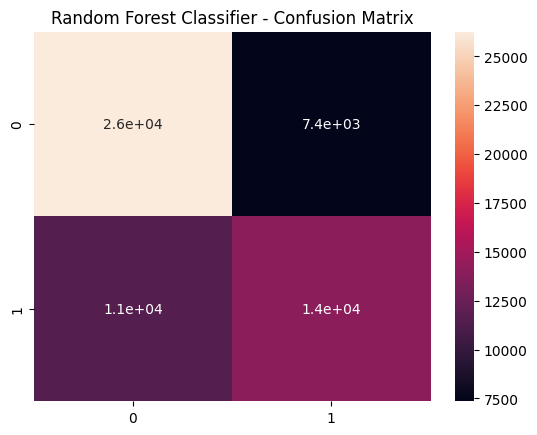

In [33]:
print("Random Forest Classifier:")
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.title('Random Forest Classifier - Confusion Matrix')
plt.show()

In [36]:
df_importances = pd.DataFrame({'feature': X.columns, 'importances': rfc.feature_importances_})
df_importances.sort_values("importances", ascending=False).head(10)

,feature,importances
0,Goal,0.077100
5,Campaign Length,0.052861
10,Count_Lowers,0.048781
6,Length_Name,0.048430
7,Name_Word_Count,0.047858
9,Count_Uppers,0.041197
3,Deadline Month,0.039136
1,Launch Month,0.038940
2,Launch Year,0.026424
4,Deadline Year,0.026400


In [21]:
#commented out for runtime purposes

# print("MLPClassifier:")
# mlp = MLPClassifier(random_state=42, max_iter=500)
# mlp.fit(X_train, y_train)
# y_pred_mlp = mlp.predict(X_test)
# print(classification_report(y_test, y_pred_mlp))
# sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d')
# plt.title('MLPClassifier - Confusion Matrix')
# plt.show()

## Random, One, and Zero Predictor

In [25]:
#50/50 classifier
binary_pred = [random.choice([0, 1]) for _ in range(len(y_test))]
classification_rep_binary = classification_report(y_test, binary_pred)
print(classification_rep_binary)

In [27]:
#all fails model
success_pred = np.ones(len(y_test))
classification_rep_succ = classification_report(y_test, success_pred)
print(classification_rep_succ)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00     33616
        True       0.43      1.00      0.60     25510

    accuracy                           0.43     59126
   macro avg       0.22      0.50      0.30     59126
weighted avg       0.19      0.43      0.26     59126



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
#all successes model
fail_pred = np.zeros(len(y_test))
classification_rep_fail = classification_report(y_test, fail_pred)
print(classification_rep_fail)

              precision    recall  f1-score   support

       False       0.57      1.00      0.72     33616
        True       0.00      0.00      0.00     25510

    accuracy                           0.57     59126
   macro avg       0.28      0.50      0.36     59126
weighted avg       0.32      0.57      0.41     59126



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Cross-Validation on Random Forest Classifier

In [ ]:
#commented out some parameters for efficiency
param_grid = {
    'n_estimators': [100], #[50, 100, 150]
    'max_depth': [None], #[None, 10, 20]
    'min_samples_split': [2], #[2, 5, 10]
    'min_samples_leaf': [1] #[1, 2, 4]
}
rfc = RandomForestClassifier(random_state=42)

#GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()
